In [1]:
import numpy as np
import argparse
import imutils
import time
import cv2
import tensorflow as tf
from huggingface_hub import from_pretrained_keras

from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt

/Users/thrilok/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


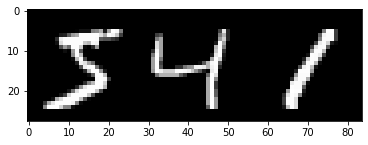

In [2]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
orig = np.zeros((28,84))
orig[:,:28] = x_train[0]
orig[:,28:56] = x_train[2]
orig[:,56:] = x_train[3]
(H,W)  = orig.shape[:2]
plt.imshow(orig,cmap='gray')

In [3]:
class SlidingWindowObjectDetection():
    def __init__(self, pretrained_classifier_path, **kwargs):
        self.model = from_pretrained_keras(pretrained_classifier_path)
        self.kwargs = kwargs
    
    def sliding_window(self, image, step, ws):
        for y in range(0, image.shape[0] - ws[1], step):
            for x in range(0, image.shape[1] - ws[0], step):
                yield (x, y, image[y:y + ws[1], x:x + ws[0]])

    def image_pyramid(self, image, scale=1.5, minSize=(28, 28)):
        yield image
        while True:
            w = int(image.shape[1] / scale)
            image = imutils.resize(image, width=w)
            if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
                break
            yield image   
            
    def get_rois_and_locs(self, pyramid):
        rois = []
        locs = []
        for image in pyramid:
            scale = W / float(image.shape[1])
            for (x, y, roiOrig) in self.sliding_window(image, self.kwargs['WIN_STEP'], self.kwargs['ROI_SIZE']):
                x = int(x * scale)
                y = int(y * scale)
                w = int(self.kwargs['ROI_SIZE'][0] * scale)
                h = int(self.kwargs['ROI_SIZE'][1] * scale)

                roi = cv2.resize(roiOrig, self.kwargs['INPUT_SIZE'])

                rois.append(roi)
                locs.append((x, y, x + w, y + h))
        return rois, locs
    
    def visualize_rois(self, rois):
        fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
        for ax, roi in zip(axes, rois):
            ax.imshow(roi, cmap='gray')
            
    def get_preds(self, rois, locs):
        rois = np.array(rois, dtype="float32")
        preds = self.model.predict(rois)
        preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
        labels = {}

        for (i, p) in enumerate(preds):
            (label, prob) = p
            if prob >= self.kwargs['MIN_CONF']:
                box = locs[i]
                L = labels.get(label, [])
                L.append((box, prob))
                labels[label] = L
        return preds, labels
    
    def apply_nms(self, labels):
        nms_labels = {}
        for label in sorted(labels.keys()):
            boxes = np.array([p[0] for p in labels[label]])
            proba = np.array([p[1] for p in labels[label]])
            boxes = non_max_suppression(boxes, proba)
            nms_labels[label] = boxes.tolist()
        return nms_labels
            
    def visualize_preds(self, img, nms_labels):
        for label in sorted(nms_labels.keys()):
            clone = img.copy()
            fig, ax = plt.subplots(figsize=(20, 6))
            boxes = nms_labels[label]
            for (startX, startY, endX, endY) in boxes:
                cv2.rectangle(clone, (startX, startY), (endX, endY), (255, 255, 255), 1)
                y = startY - 10 if startY - 10 > 10 else startY + 10
                cv2.putText(clone, str(label), (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)
            ax.imshow(clone, cmap='gray')
    
    def __call__(self, img):
        pyramid = self.image_pyramid(img, scale=self.kwargs['PYR_SCALE'], minSize=self.kwargs['ROI_SIZE'])
        rois, locs = self.get_rois_and_locs(pyramid)
        if self.kwargs['VIZ_ROIS']:
            self.visualize_rois(rois)
        preds, labels = self.get_preds(rois, locs)
        nms_labels = self.apply_nms(labels)
        
        if self.kwargs['VISUALIZE']:
            self.visualize_preds(img, nms_labels)
        
        return nms_labels

In [4]:
kwargs = dict(
PYR_SCALE = 1.25,
WIN_STEP=7,
ROI_SIZE=(21,21),
INPUT_SIZE=(28,28),
VISUALIZE=True,
MIN_CONF=0.8,
VIZ_ROIS=True
)

config.json not found in HuggingFace Hub


Metal device set to: Apple M1


2022-04-22 20:36:25.588216: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-22 20:36:25.588324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-22 20:36:29.067220: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-22 20:36:29.202389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


predictions:  {1: [[52, 0, 78, 26]], 2: [[21, 0, 42, 21]], 3: [[8, 0, 34, 26]], 4: [[26, 0, 52, 26]], 5: [[0, 0, 26, 26]], 7: [[14, 0, 35, 21]]}


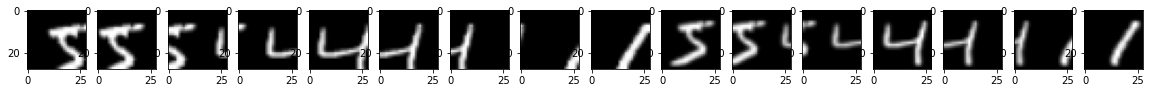

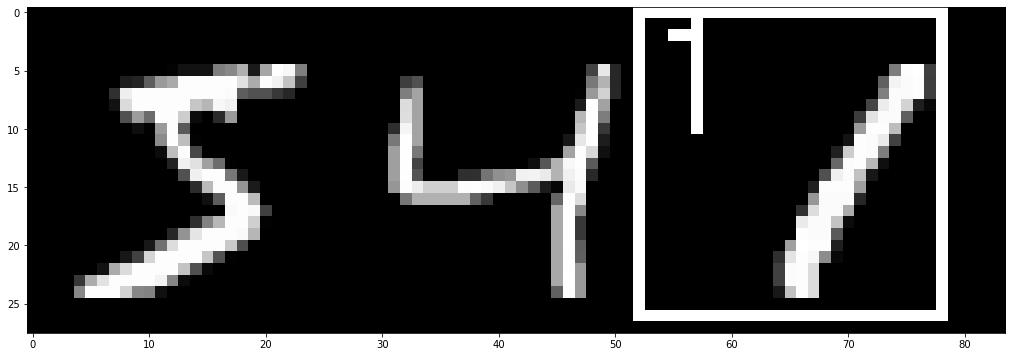

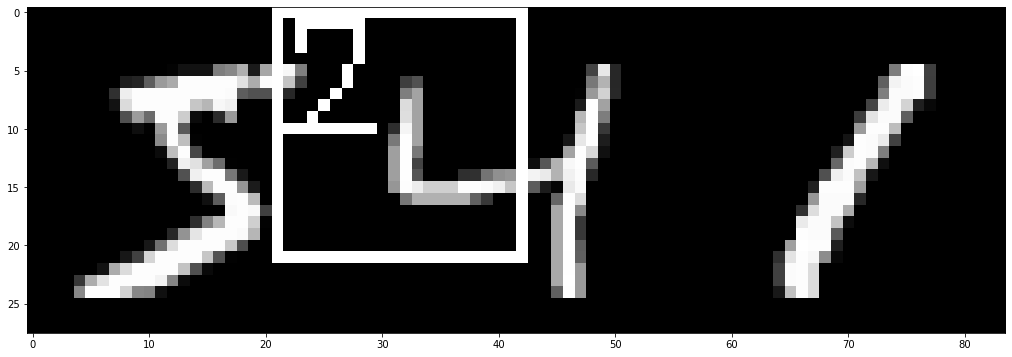

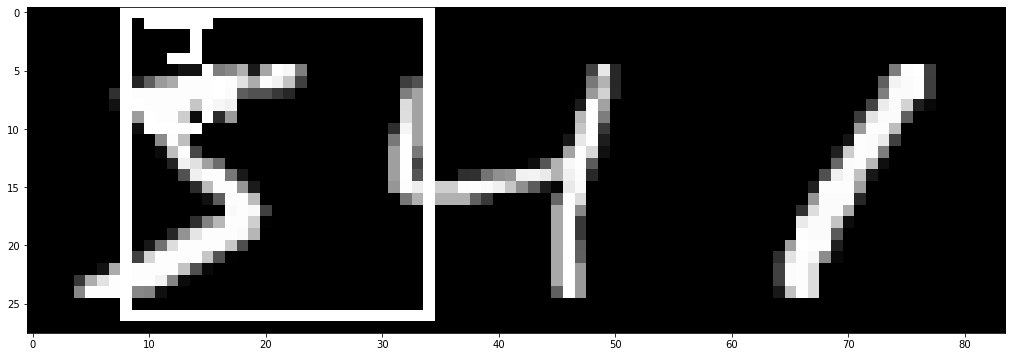

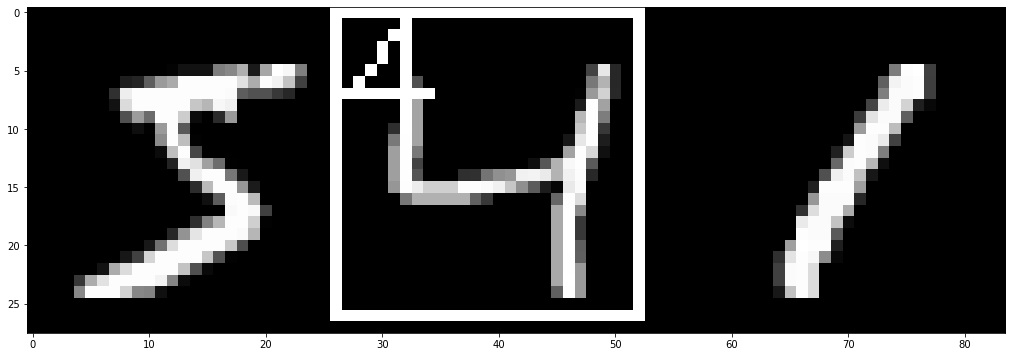

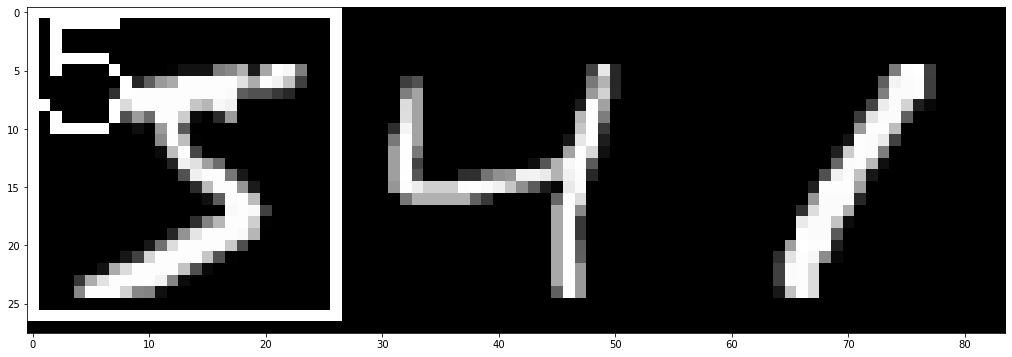

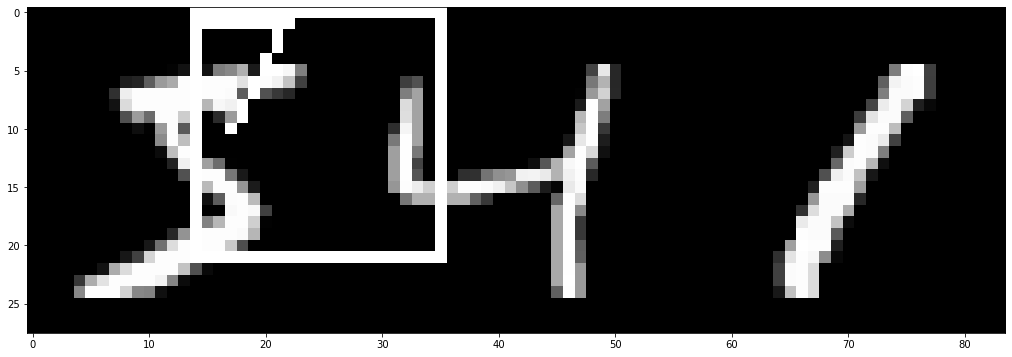

In [5]:
model = SlidingWindowObjectDetection('Ritvik19/mnist-net', **kwargs)
preds = model(orig)
print("predictions: ", preds)